In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('/home/jovyan/work/dkfinance_modeller'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [9]:
import os
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import dkfinance_modeller.aktieskat.depotmodel as depotmodel
import dkfinance_modeller.aktieskat.kurtage as kurtage
import dkfinance_modeller.aktieskat.skat as skat
import dkfinance_modeller.aktieskat.vaerdipapirer as værdipapirer
import dkfinance_modeller.aktieskat.valuta as valuta
import dkfinance_modeller.simple_modeller.formler as formler

In [10]:

def depoter(kapital : float) -> Tuple[depotmodel.DepotModel, depotmodel.DepotModel]:
    """Definere depoter.

    Returns:
      Depot med realationsbeskatning
    """
    etf1 = værdipapirer.ETF(kurs=100, åop=0.12 / 100)
    etf2 = værdipapirer.ETF(kurs=100, åop=0.55 / 100)
    lagerbeskatning = depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(valuta="euro", valutakurs=7.44, underkonto=True),
        skattefunktion=skat.aktiebeskatning,
        minimumskøb=5000,
        beskatningstype="lager",
        ETFer=[etf1],
        ETF_fordeling=[1.0],
        valutafunktion=valuta.saxo_underkonto_kurtage,
    )
    realisationsbeskatning = depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(valuta="Dkk"),
        skattefunktion=skat.aktiebeskatning,
        minimumskøb=5000,
        beskatningstype="realisation",
        ETFer=[etf2],
        ETF_fordeling=[1.0],
    )
    return lagerbeskatning, realisationsbeskatning

In [313]:
data = np.genfromtxt("../SP500.csv", delimiter=";")
real: List[List[float]] = [[], [], [], []]
lager: List[List[float]] = [[], [], [], []]
out = pd.DataFrame({'kapital': pd.Series([], dtype='float64'),
                   'periode': pd.Series([], dtype='category'),
                   'start': pd.Series([], dtype='int64'),
                   'type': pd.Series([], dtype='category'),
                   'salgsværdi': pd.Series([], dtype='float64')})
for kapital in [50000, 100000,150000,200000,  300000, 1000000 ]:
    for j, antal_år in enumerate([1, 5, 10, 20]):
        for start in range(0, len(data) - 950 - antal_år * 12):
            lagerdepot, realisationsdepot = depoter(kapital)
            udbytte_årlig = 0.0
            kursstigning_årlig = 0.0
            for i in range(start + 950, start + 950 + 12 * antal_år):
                udbytteafkast_real = realisationsdepot.ETFer[0].kurs * data[i + 1, 4]
                kursafkast_real = realisationsdepot.ETFer[0].kurs * data[i + 1, 3]
                udbytteafkast_lager = lagerdepot.ETFer[0].kurs * data[i + 1, 4]
                kursafkast_lager = lagerdepot.ETFer[0].kurs * data[i + 1, 3]
                if i % 12 == 0:
                    effektivt_udbytte = udbytte_årlig + max(0, 0.3 * kursstigning_årlig)
                    realisationsdepot.afkast_månedlig(
                        [udbytteafkast_real + kursafkast_real - effektivt_udbytte], [effektivt_udbytte]
                    )
                    udbytte_årlig = 0.0
                    kursstigning_årlig = 0.0
                else:
                    realisationsdepot.afkast_månedlig([udbytteafkast_real + kursafkast_real], [0.0])
                lagerdepot.afkast_månedlig([udbytteafkast_lager + kursafkast_lager], [0.0])
                udbytte_årlig += udbytteafkast_real
                kursstigning_årlig += kursafkast_real
            out = out.append(pd.DataFrame({'kapital': pd.Series([kapital, kapital], dtype='float64'),
                                    'periode': pd.Series([antal_år, antal_år], dtype='category'),
                                    'start': pd.Series([start, start], dtype='int64'),
                                    'type': pd.Series(['real', 'lager'], dtype='category'),
                                    'salgsværdi': pd.Series([realisationsdepot.total_salgsværdi(), lagerdepot.total_salgsværdi()], dtype='float64')}))

out['CAGR'] = ((out['salgsværdi']/out['kapital'])**(1/out['periode']) -1).astype(float)
out2 = out.set_index(['kapital', 'periode', 'start', 'type'])

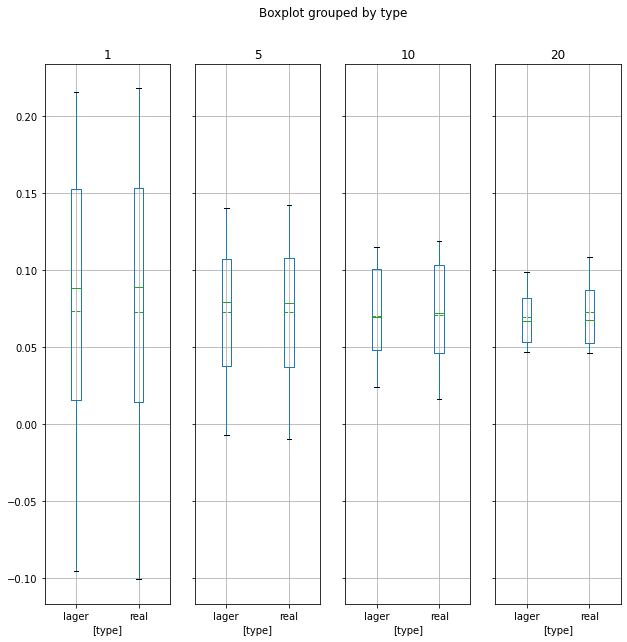

In [315]:
boxplt = out2[['CAGR']].groupby(['periode']).boxplot(by = 'type', figsize = [10,10], sym = '', whis = [10, 90], meanline = True, showmeans = True, layout = (1,4))

/opt/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/opt/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/opt/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/opt/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


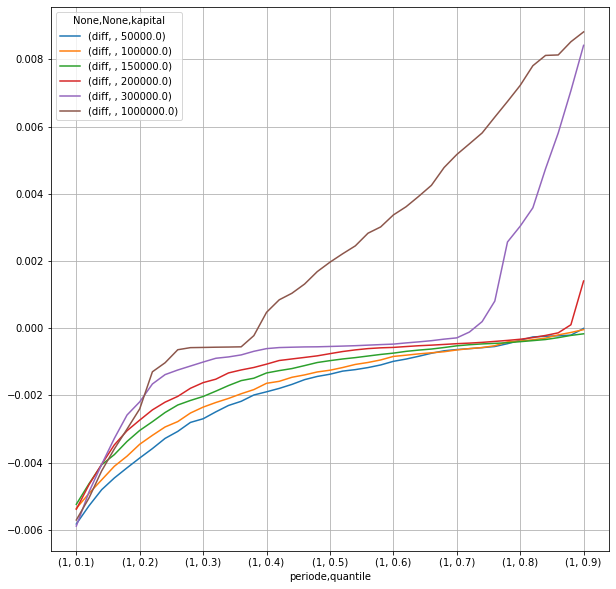

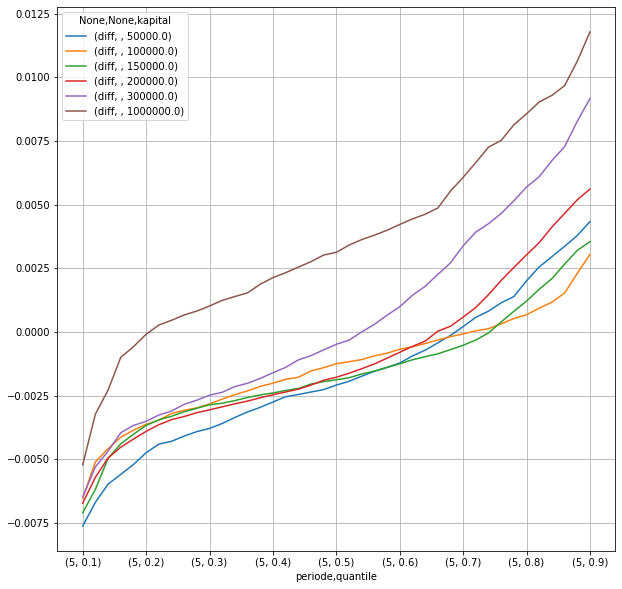

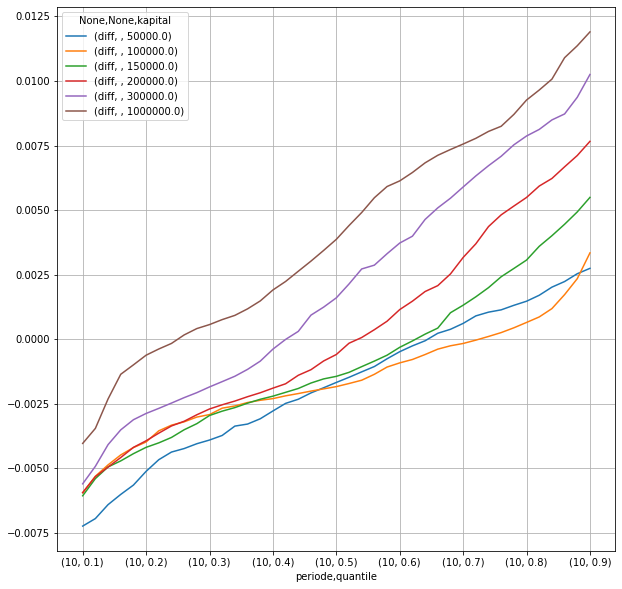

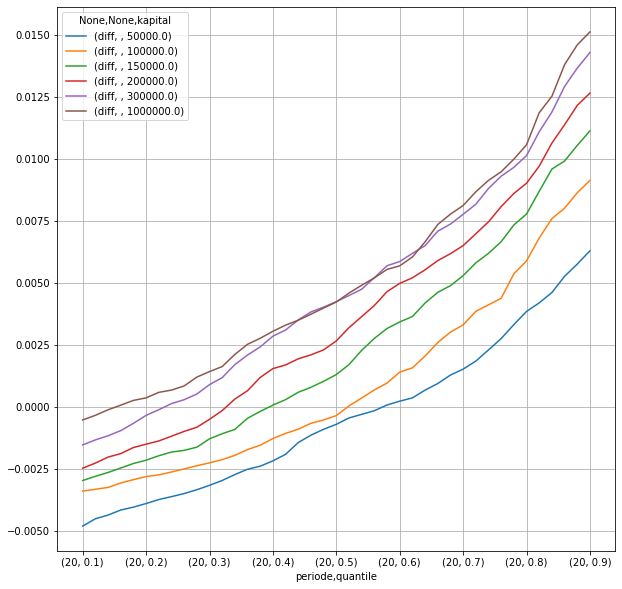

In [318]:
var = out2[['CAGR']].unstack('type')
var['diff'] = var['CAGR','real'] - var['CAGR','lager']
var = var[['diff']].groupby(['kapital', 'periode']).quantile(np.linspace(0.1,0.9,num=41).round(2))
var.index.names = ['kapital', 'periode', 'quantile']
varplt = var.unstack('kapital').groupby('periode').plot(by = 'quantile', grid=True, figsize = [10,10], layout = (1,4)) #BEST SO FAR

In [250]:
quantile.loc(axis=0)[300000,20,:,0]

CAGR
kapital  periode type  quantile          
300000.0 20      lager 0.0       0.034328
                 real  0.0       0.031799

In [144]:
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
quantile2.groupby(['kapital','type','quantile']).unstack().plot(by = 'quantile', ax=ax)

In [ ]:
quanti

TESTS

In [33]:
def depoter() -> Tuple[depotmodel.DepotModel, depotmodel.DepotModel]:
    """Definere depoter.

    Returns:
      Depot med realationsbeskatning
    """
    etf1 = værdipapirer.ETF(kurs=100, åop=0.1 / 100)
    etf2 = værdipapirer.ETF(kurs=100, åop=0.1 / 100)
    lagerbeskatning = depotmodel.DepotModel(
        kapital=300000.0,
        kurtagefunktion=kurtage.nulkurtage,
        skattefunktion=skat.aktiebeskatning,
        minimumskøb=5000,
        beskatningstype="lager",
        ETFer=[etf1],
        ETF_fordeling=[1.0],
    )
    realisationsbeskatning = depotmodel.DepotModel(
        kapital=300000.0,
        kurtagefunktion=kurtage.nulkurtage,
        skattefunktion=skat.aktiebeskatning,
        minimumskøb=5000,
        beskatningstype="realisation",
        ETFer=[etf2],
        ETF_fordeling=[1.0],
    )
    return lagerbeskatning, realisationsbeskatning

In [34]:
lagerdepot, realisationsdepot = depoter()
for _ in range(0, 12):
    realisationsdepot.afkast_månedlig([0.0], [5000/realisationsdepot.ETFer[0].antal_værdipapirer])
    lagerdepot.afkast_månedlig([5000/lagerdepot.ETFer[0].antal_værdipapirer], [0.0])
    print(realisationsdepot.total_salgsværdi(), lagerdepot.total_salgsværdi())

304974.9885343407 303631.43732390326
309949.9791539261 307262.57188924006
314924.138282071 310893.4037212519
319897.88281110197 314523.9328451781
324871.2128103302 318154.159286256
329844.12834905833 321784.08306972065
334816.62949658005 325413.7042208052
339788.71632218047 329043.0227647404
344760.38889513613 332672.0387267552
349731.64728471474 336300.7521320763
354702.4915601755 339929.16300592833
342767.9217907688 342902.147118698


In [35]:
lagerdepot, realisationsdepot = depoter()
for _ in range(0, 12):
    realisationsdepot.afkast_månedlig([0.0], [0/realisationsdepot.ETFer[0].antal_værdipapirer])
    lagerdepot.afkast_månedlig([0/lagerdepot.ETFer[0].antal_værdipapirer], [0.0])
    print(realisationsdepot.total_salgsværdi(), lagerdepot.total_salgsværdi())

299974.9885343407 299974.9885343407
299949.97915392614 299949.97915392614
299924.9718585824 299924.9718585824
299899.96664813574 299899.96664813574
299874.9635224123 299874.9635224123
299849.9624812382 299849.9624812382
299824.9635244398 299824.9635244398
299799.96665184316 299799.96665184316
299774.9718632746 299774.9718632746
299749.97915856034 299749.97915856034
299724.9885375267 299724.9885375267
299699.99999999994 299699.99999999994


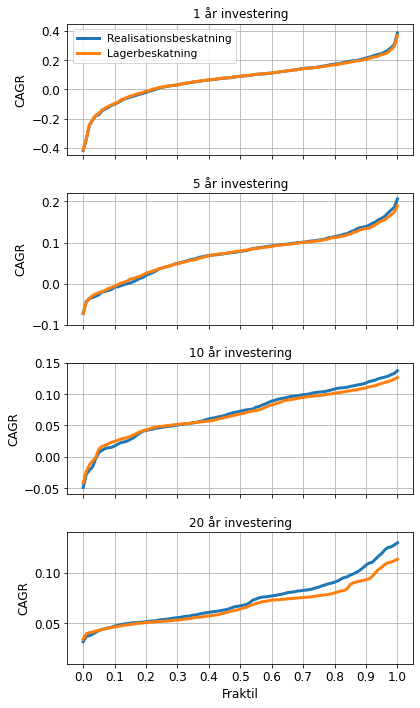

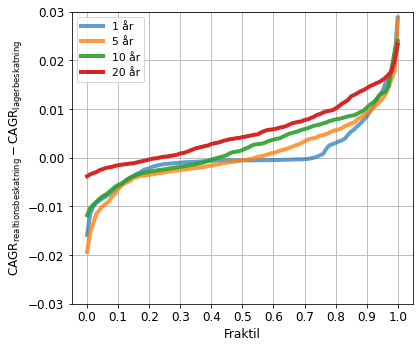

In [36]:
SIZE = 12
plt.rc("font", size=SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE)  # fontsize of the x any y labels
plt.rc("xtick", labelsize=SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SIZE * 0.9)  # legend fontsize
plt.rc("figure", titlesize=SIZE)  # # size of the figure title

q_real: List[List[float]] = [[], [], [], []]
q_lager: List[List[float]] = [[], [], [], []]
for i in range(0, 101):
    q_real[0].append(np.quantile(real_carg_1år, i * 0.01))  # type: ignore
    q_real[1].append(np.quantile(real_carg_5år, i * 0.01))  # type: ignore
    q_real[2].append(np.quantile(real_carg_10år, i * 0.01))  # type: ignore
    q_real[3].append(np.quantile(real_carg_20år, i * 0.01))  # type: ignore
    q_lager[0].append(np.quantile(lager_carg_1år, i * 0.01))  # type: ignore
    q_lager[1].append(np.quantile(lager_carg_5år, i * 0.01))  # type: ignore
    q_lager[2].append(np.quantile(lager_carg_10år, i * 0.01))  # type: ignore
    q_lager[3].append(np.quantile(lager_carg_20år, i * 0.01))  # type: ignore

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(6, 10), sharex=True)
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.plot(np.linspace(0.0, 1, 101), q_real[i], label="Realisationsbeskatning", linewidth=3)
    ax.plot(np.linspace(0.0, 1, 101), q_lager[i], label="Lagerbeskatning", linewidth=3)
ax1.legend()
for ax, år in zip([ax1, ax2, ax3, ax4], [1, 5, 10, 20]):
    ax.set_xticks(np.linspace(0.0, 1.0, 11))
    ax.grid(which="minor")
    ax.grid(which="major")
    ax.set_ylabel(f"CAGR")
    ax.set_title(f"{år:1.0f} år investering")
ax1.set_ylim(-0.45, 0.45)
ax2.set_ylim(-0.1, 0.22)
ax3.set_ylim(-0.06, 0.15)
ax4.set_ylim(0.01, 0.14)
ax4.set_xlabel("Fraktil")
plt.tight_layout()
plt.savefig("fraktiler.svg")

q: List[List[float]] = [[], [], [], []]
for i in range(0, 101):
    q[0].append(np.quantile(real_carg_1år - lager_carg_1år, i * 0.01))  # type: ignore
    q[1].append(np.quantile(real_carg_5år - lager_carg_5år, i * 0.01))  # type: ignore
    q[2].append(np.quantile(real_carg_10år - lager_carg_10år, i * 0.01))  # type: ignore
    q[3].append(np.quantile(real_carg_20år - lager_carg_20år, i * 0.01))  # type: ignore

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
for i, år in enumerate([1, 5, 10, 20]):
    ax1.plot(np.linspace(0.0, 1, 101), q[i], label=f"{år:1.0f} år", linewidth=4, alpha=0.7 + 0.1 * i)
ax1.legend()
ax1.set_xticks(np.linspace(0.0, 1.0, 11))
ax1.grid(which="minor")
ax1.grid(which="major")
ax1.set_ylabel(r"$\mathrm{CAGR_{realtionsbeskatning}} - \mathrm{CAGR_{lagerbeskatning}}$")
ax1.set_ylim(-0.03, 0.03)
ax1.set_xlabel("Fraktil")
plt.tight_layout()
plt.savefig("real_lager_fraktiler.svg")

assert abs(q_real[0][-1] - 0.38709653149381973) < 10 ** -6
assert abs(q_real[1][-1] - 0.2061982584274995) < 10 ** -6
assert abs(q_real[2][-1] - 0.13726171826822742) < 10 ** -6
assert abs(q_real[3][-1] - 0.12953685759662048) < 10 ** -6
assert abs(q_lager[0][-1] - 0.36764156034398776) < 10 ** -6
assert abs(q_lager[1][-1] - 0.18917409019258113) < 10 ** -6
assert abs(q_lager[2][-1] - 0.12640534942760162) < 10 ** -6
assert abs(q_lager[3][-1] - 0.11330807298417156) < 10 ** -6